## `Introduction`


YouTube stands as the world's foremost video-sharing platform, drawing in over 2 billion logged-in users each month who watch more than a billion hours of video daily. Understanding the factors that cause videos to trend on the platform is incredibly valuable for content creators, marketers, and researchers. This notebook provides an in-depth analysis of trending YouTube videos from Canada, aiming to uncover the key patterns and elements that drive video popularity and success.

## `Research Questions`


`In this analysis, we seek to answer the following questions:`

`1. Category-Based Insights`

- Which category_name has the highest average views or trending frequency?

- How do viewer engagement metrics differ across categories like Music, News, Gaming, etc.?

- What trends can we observe overall?
  
`2. Engagement & Popularity`

- Which engagement metric (likes, dislikes, comments) most strongly correlates with trending success (views)?

- Are videos with higher like-to-dislike ratios more likely to have higher view counts?

- Do videos with comments disabled or ratings disabled trend differently than those with full engagement enabled?

`3. Temporal Analysis`

- What is the average time delay between publish_time and trending_date across categories?

- Are there specific days of the week or times of day where videos are more likely to trend?

- How does the trending frequency vary across different months or seasons?

`4. Content Metadata & Strategy`

- Do certain tags or patterns in tags appear more frequently in trending videos?

- How does title length or presence of clickbait-style words (e.g., "shocking", "you won’t believe") affect views or engagement?

`5. Creator & Channel Influence`

- Which channel_title consistently appears on the trending list, and what are their common traits?

- Do channels with repeated trending videos use consistent video formats, or categories?

`6. Video Status & Restrictions`

- What is the impact of comments_disabled, ratings_disabled, or video_error_or_removed on engagement?

- Do videos that are later removed or error out tend to have unusually high or low engagement?


## `Imports and Setup`

In [1]:
# This lets Python find and import modules located two folders above the current directory.

import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent.parent))

In [2]:
from src.preprocessing.merge_datasets import dataset_merger
from src.preprocessing.data_utils import *
from src.analysis.category_trends import *
from src.analysis.engagement import *
from src.visualization.plot_engagement import *
from src.visualization.plot_trends import *

`Dataset Merge: US (Videos + Categories)`

Merging `USvideos.csv` with `US_category_id.json` using a right join to retain all category records.  
File paths are converted from `Path` objects to strings to ensure compatibility with the merging function.

In [3]:
US_csv_path = Path("../../data/US/USvideos.csv")
US_json_path= Path("../../data/US/US_category_id.json")

US_data = dataset_merger([str(US_csv_path), str(US_json_path)], how='right')
US_data.head(3)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,category_name
0,jr9QtXwC9vc,17.14.11,The Greatest Showman | Official Trailer 2 [HD]...,20th Century Fox,1,2017-11-13T14:00:23.000Z,"Trailer|""Hugh Jackman""|""Michelle Williams""|""Za...",826059.0,3543.0,119.0,340.0,https://i.ytimg.com/vi/jr9QtXwC9vc/default.jpg,False,False,False,"Inspired by the imagination of P.T. Barnum, Th...",Film & Animation
1,n30k5CwLhS4,17.14.11,Nick Andopolis: Drummer,FaeryInLoveInc,1,2011-05-29T17:03:12.000Z,"freaks and geeks|""jason segel""|""judd apatow""|""...",50867.0,715.0,238.0,246.0,https://i.ytimg.com/vi/n30k5CwLhS4/default.jpg,False,False,False,"The opening of Freaks and Geeks Episode 6, I'm...",Film & Animation
2,Om_zGhJLZ5U,17.14.11,TL;DW - Every DCEU Movie Before Justice League,Screen Junkies,1,2017-11-12T18:00:03.000Z,"screenjunkies|""screen junkies""|""sj news""|""hone...",288922.0,7515.0,792.0,2111.0,https://i.ytimg.com/vi/Om_zGhJLZ5U/default.jpg,False,False,False,With Justice League approaching fast we rewatc...,Film & Animation


## `Preprocessing`

In [4]:
# Remove columns that are irrelevant or not useful for exploratory analysis,
# such as unique IDs, thumbnail URLs, and long unstructured text fields

columns_to_drop = [
    'thumbnail_link',
    'category_id',
    'description'
]

US_data = drop_columns(US_data, columns_to_drop)

In [5]:
US_data.isna().sum()

video_id                  16
trending_date             16
title                     16
channel_title             16
publish_time              16
tags                      16
views                     16
likes                     16
dislikes                  16
comment_count             16
comments_disabled         16
ratings_disabled          16
video_error_or_removed    16
category_name              0
dtype: int64

Since it's only 16 missing rows out of thousands, it's safe to drop those rows entirely.

In [6]:
# Drop rows with missing values (16 rows only) to clean the dataset for EDA
US_data = handle_missing_values(US_data, strategy='drop')

In [7]:
# Convert the 'trending_date' column in US_data to datetime format.
# The original format is 'yy.dd.mm' (e.g., '17.14.11' for 14th November 2017).
US_data = convert_to_datetime(US_data, 'trending_date', '%y.%d.%m')

# Convert the 'publish_time' column to datetime format using pandas.
# This ensures that we can perform date/time operations or filtering.
US_data['publish_time'] = pd.to_datetime(US_data['publish_time'])

`Extract date parts from publish_time`

In [8]:
US_data['publish_day'] = US_data['publish_time'].dt.date
US_data['publish_hour'] = US_data['publish_time'].dt.hour
US_data['publish_weekday'] = US_data['publish_time'].dt.day_name()

`Calculate "Days to Trend"`

In [9]:
#Poth without timezone
US_data['publish_time'] = US_data['publish_time'].dt.tz_localize(None)

US_data['days_to_trend'] = (US_data['trending_date'] - US_data['publish_time']).dt.days

In [10]:
US_data.head(3)

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,video_error_or_removed,category_name,publish_day,publish_hour,publish_weekday,days_to_trend
0,jr9QtXwC9vc,2017-11-14,The Greatest Showman | Official Trailer 2 [HD]...,20th Century Fox,2017-11-13 14:00:23,"Trailer|""Hugh Jackman""|""Michelle Williams""|""Za...",826059.0,3543.0,119.0,340.0,False,False,False,Film & Animation,2017-11-13,14,Monday,0
1,n30k5CwLhS4,2017-11-14,Nick Andopolis: Drummer,FaeryInLoveInc,2011-05-29 17:03:12,"freaks and geeks|""jason segel""|""judd apatow""|""...",50867.0,715.0,238.0,246.0,False,False,False,Film & Animation,2011-05-29,17,Sunday,2360
2,Om_zGhJLZ5U,2017-11-14,TL;DW - Every DCEU Movie Before Justice League,Screen Junkies,2017-11-12 18:00:03,"screenjunkies|""screen junkies""|""sj news""|""hone...",288922.0,7515.0,792.0,2111.0,False,False,False,Film & Animation,2017-11-12,18,Sunday,1


##### Data is Ready for Analysis

Now that the dataset has been cleaned and all relevant features have been extracted, we are ready to begin the Exploratory Data Analysis (EDA). The final dataframe includes the following columns:

- `video_id`
- `trending_date`
- `title`
- `channel_title`
- `publish_time`
- `tags`
- `views`
- `likes`
- `dislikes`
- `comment_count`
- `comments_disabled`
- `ratings_disabled`
- `video_error_or_removed`
- `category_name`
- `publish_day`
- `publish_hour`
- `publish_weekday`
- `days_to_trend`

Let's move on to uncover trends, patterns, and insights!

## `Analysis`

### `1. Category-Based Insights`

- Which category_name has the highest average views or trending frequency?

- How do viewer engagement metrics differ across categories like Music, News, Gaming, etc.?

- What trends can we observe overall?

In [11]:
extract_categories(US_data, category_column='category_name')

['Film & Animation',
 'Autos & Vehicles',
 'Music',
 'Pets & Animals',
 'Sports',
 'Travel & Events',
 'Gaming',
 'People & Blogs',
 'Comedy',
 'Entertainment',
 'News & Politics',
 'Howto & Style',
 'Education',
 'Science & Technology',
 'Nonprofits & Activism',
 'Shows']

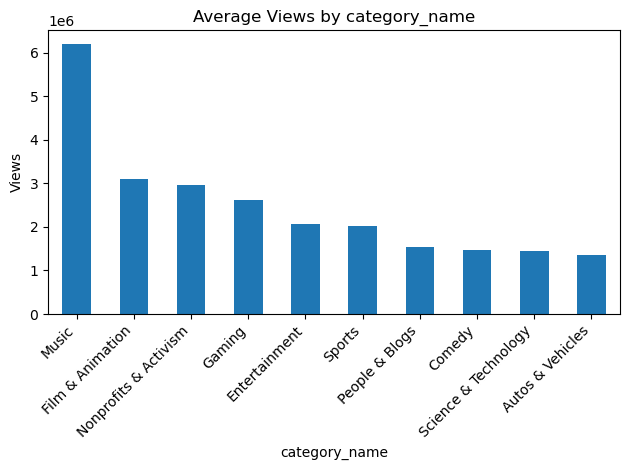

In [12]:
fig = plot_trend_comparison(US_data,group_col='category_name', value_col='views' )
plt.show()

path = '../../outputs/plots/country_specific/US/avg_views_by_category_name'
export_trend_plot(fig, str(path))

- `Which category has the highest average views or trending frequency?`

- The "Music" category has the highest average views, exceeding 5 million, based on US data.
- This suggests "Music" is also likely the most trending category due to its strong engagement.

#### Insights
- The dominance of "Music" indicates its widespread popularity and potential as a key focus area.
- Further analysis of trending sub-genres or artists could refine this insight.

In [13]:
growth_monthly =calculate_category_growth(data=US_data.rename(columns={'trending_date': 'date'}),\
                                           category_column='category_name', value_column='views', top_n=5, freq="M")

path = '../../outputs/tables/country_specific/US/Top 5 Category Growth Monthly'
save_table(growth_monthly, str(path), format='csv')
growth_monthly

category_name,Comedy,Entertainment,Film & Animation,Music,People & Blogs
period,,,,,
2017-11-01,0.000000,0.000000,0.000000,0.000000,0.000000
2017-12-01,107.170567,267.300665,-20.839264,23.143270,339.550827
2018-01-01,-3.867466,-57.710462,37.626470,-8.975362,-18.225940
2018-02-01,-27.019565,19.361701,109.366075,-8.279143,136.821460
2018-03-01,75.487267,72.997074,-14.415104,109.699112,-32.239344
2018-04-01,14.976860,18.053606,10.647734,62.544592,10.404078
2018-05-01,-7.883461,73.824224,84.598772,136.219133,58.402780
2018-06-01,-36.202790,-52.635488,-16.882947,-54.158052,-30.637583


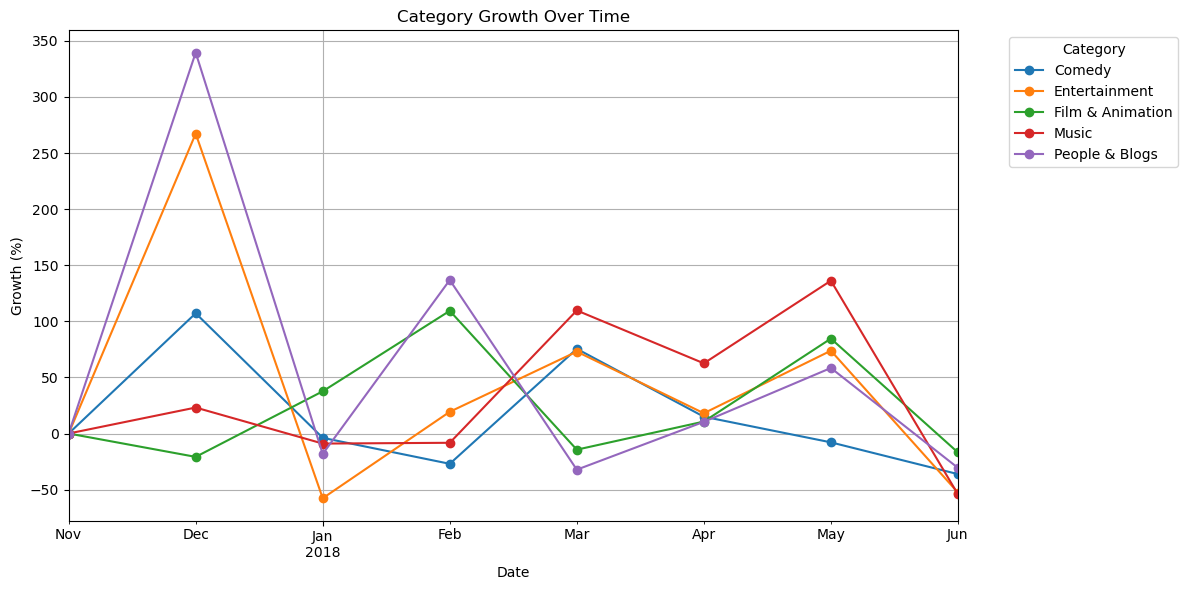

In [14]:
fig = plot_category_growth(growth_monthly)

path = '../../outputs/plots/country_specific/US/category_growth_over_time'
export_trend_plot(fig, str(path))

- `What trends can we observe overall?`

- The line chart tracks the percentage growth of categories (Comedy, Entertainment, Film & Animation, Music, People & Blogs) from November 2017 to June 2018.
- **Peak Growth**: The highest growth peaks occur in December 2017, with "People & Blogs" reaching over 300% and "Entertainment" around 250%.
- **Decline Trends**: Most categories show a decline after their peaks, with "People & Blogs" dropping sharply to below 0% by March 2018, and "Music" declining from a peak in May 2018.
- **Fluctuations**: Categories like "Film & Animation" and "Comedy" exhibit moderate growth with fluctuations, while "Music" shows a late surge in May before declining.
- **Overall Trend**: Growth is volatile, with an initial spike in late 2017, followed by a general decline or stabilization into mid-2018.

#### Insights
- **Seasonal Impact**: The high growth in December may reflect seasonal interest (e.g., holiday content), particularly for "People & Blogs" and "Entertainment".
- **Sustainability Concerns**: Sharp declines (e.g., "People & Blogs") suggest temporary spikes rather than sustained growth, possibly due to one-off events or trends.
- **Late Surge in Music**: The "Music" category's growth in May indicates a potential emerging trend or campaign worth investigating.
- **Strategy Adjustment**: Focus on sustaining interest post-peak and identifying drivers of late growth in "Music".

In [15]:
category_engagement =  summarize_engagement_by_category_df(US_data)

path = '../../outputs/tables/country_specific/US/Avg Eategory Engagement '
save_table(category_engagement, str(path), format='csv')

category_engagement

,category_name,video_count,total_likes,total_comments,total_views,avg_engagement_rate
0,Autos & Vehicles,384,4.245656e+06,784447.0,5.206907e+08,2.039377
1,Comedy,3457,2.163467e+08,22545582.0,5.117426e+09,4.910213
2,Education,1656,4.925777e+07,5442242.0,1.180630e+09,4.226658
3,Entertainment,9964,5.305165e+08,73566498.0,2.060439e+10,3.242717
4,Film & Animation,2345,1.659975e+08,17887060.0,7.284157e+09,3.098059
5,Gaming,817,6.903828e+07,14740713.0,2.141219e+09,4.475865
6,Howto & Style,4146,1.628801e+08,23149550.0,4.078545e+09,5.088289
7,Music,6472,1.416839e+09,125296396.0,4.013289e+10,5.142622
8,News & Politics,2487,1.815103e+07,6039433.0,1.473766e+09,1.911164
9,Nonprofits & Activism,57,1.481565e+07,4808797.0,1.689414e+08,4.520991


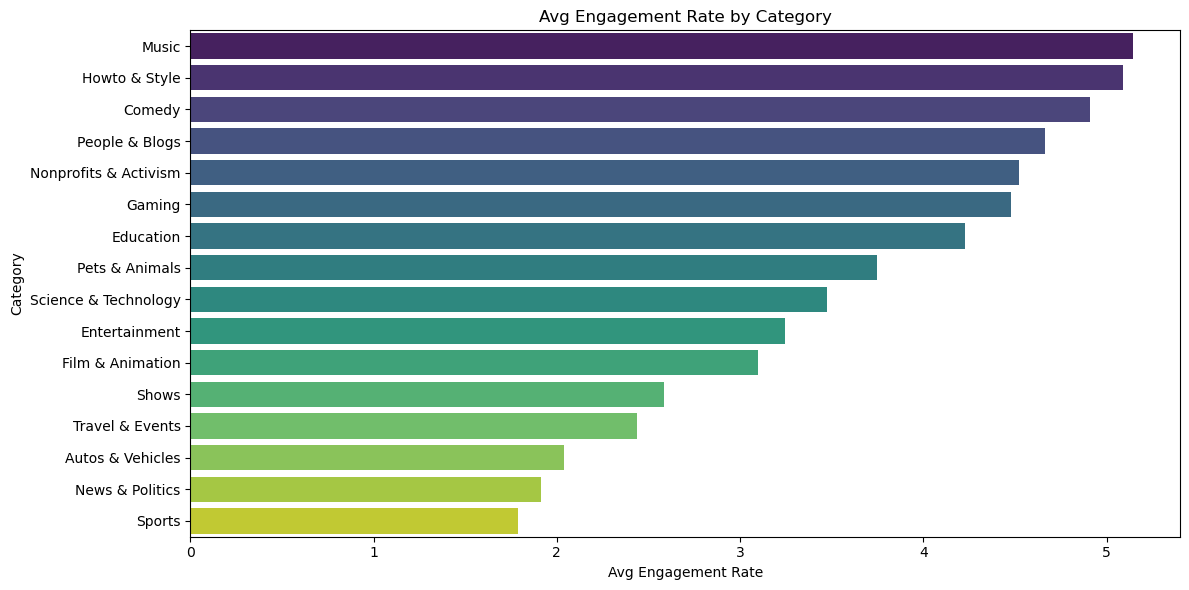

In [16]:
fig = plot_category_engagement(category_engagement)

path = '../../outputs/plots/country_specific/US/avg_engagement_rate_by_category'
export_trend_plot(fig, str(path))

- `How do viewer engagement metrics differ across categories like Music, News, Gaming, etc.?`


- **Engagement Rate (%)** = ((likes + comment_count) ÷ views) × 100  
  > Based on likes and comments — key indicators of positive interaction.

---

#### 🔝 Highest Engagement Categories:
| Category           | Avg Engagement Rate |
|--------------------|---------------------|
| Music              | ~5.2                |
| Howto & Style      | ~5.1                |
| Comedy             | ~4.9                |
| People & Blogs     | ~4.7                |
| Nonprofits & Activism | ~4.5               |
| Gaming             | ~4.4                |

- *Music* and *Howto & Style* lead in engagement, indicating audiences are most interactive in these categories.
- *Comedy*, *People & Blogs*, and *Gaming* also demonstrate very strong community interaction, ranking in the top tier.
- Niche categories like *Nonprofits & Activism* perform exceptionally well, suggesting strong community relevance.

---

#### 🔻 Lowest Engagement Categories:
| Category            | Avg Engagement Rate |
|---------------------|---------------------|
| Sports              | ~1.8                |
| News & Politics     | ~1.9                |
| Autos & Vehicles    | ~2.2                |
| Travel & Events     | ~2.6                |
| Shows               | ~2.8                |

- Lower engagement likely due to:
  - More passive viewing habits (e.g., *News*, *Shows*).
  - Broader, less targeted audiences for categories like *Sports*.
  - Engagement for these topics might be happening on other, more specialized platforms.

---

#### 💡 Key Takeaways:
- **High views ≠ High engagement** — categories like *Entertainment* (~3.3) may attract large viewership but have moderate interaction rates compared to the top performers.
- For building **active communities**, data suggests focusing on *Music*, *Howto & Style*, and *Comedy*.
- Content in lower-engagement categories like *Sports* and *News & Politics* requires distinct strategies (e.g., calls-to-action, polls) to encourage viewer interaction.

### `2. Engagement & Popularity`

- Which engagement metric (likes, dislikes, comments) most strongly correlates with trending success (views)?

- Are videos with higher like-to-dislike ratios more likely to have higher view counts?

- Do videos with comments disabled or ratings disabled trend differently than those with full engagement enabled?

In [17]:
print_engagement_correlation_before_trend(US_data)


 Correlation Between Pre-Trend Daily Engagement and Trending Success (Views/day)

- Likes/day      : 0.833
- Comments/day   : 0.613
- Dislikes/day   : 0.562


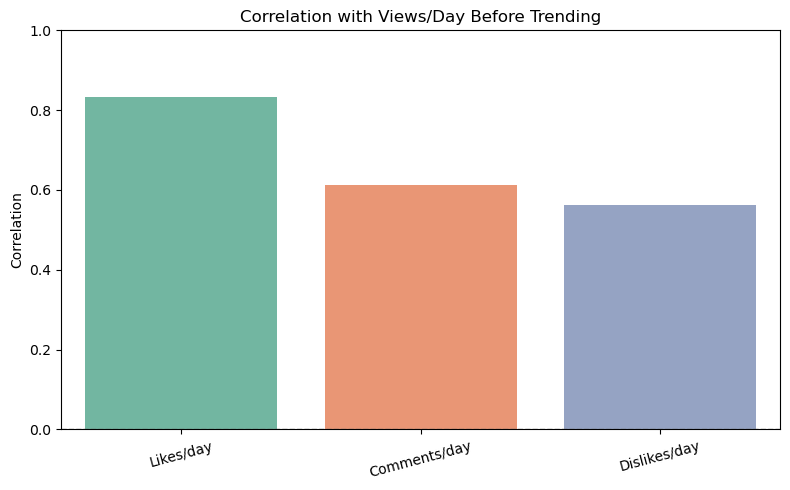

In [18]:
engagement_correlation_before_trend = plot_engagement_correlation_before_trend(US_data)
plt.show()

path = '../../outputs/plots/country_specific/US/correlation_with_views_per_day_before_trending'
export_trend_plot(engagement_correlation_before_trend, str(path))

- `Insights: Correlation Between Pre-Trend Engagement and Views per Day`

**Focus:** Engagement metrics from video publish date to trending date, measured per day.

| Metric          | Correlation with Views/Day |
|------------------|----------------------------|
| Likes/day        | **~0.83** (Strongest)      |
| Comments/day     | **~0.61** (Strong)         |
| Dislikes/day     | **~0.56** (Moderate)       |

#### 🔍 Insights:
- **Likes/day** → The strongest predictor of trending success, showing that immediate positive audience feedback is critical.
- **Comments/day** → Also strongly correlated → suggests that active discussion and community engagement are key drivers for gaining visibility before trending.
- **Dislikes/day** → Moderately correlated → indicates that while all engagement contributes, negative reactions are less correlated with pre-trending views than positive feedback or comments.

➡️ **Conclusion:** Positive audience feedback (Likes) and active discussion (Comments) are the most powerful indicators of a video's potential to trend.

In [19]:
like_dislike_ratio_vs_views = like_dislike_ratio_vs_views(US_data)

path = '../../outputs/tables/country_specific/US/Like Dislike Ratio VS Views'
save_table(like_dislike_ratio_vs_views, path, format='csv')

like_dislike_ratio_vs_views

Correlation between like/dislike ratio and average views: 0.235


,category_name,avg_like_dislike_ratio,avg_views
7,Music,59.019921,6.201003e+06
4,Film & Animation,38.232259,3.106250e+06
9,Nonprofits & Activism,27.103074,2.963884e+06
5,Gaming,34.474980,2.620831e+06
3,Entertainment,38.150676,2.067883e+06
14,Sports,27.012665,2.025969e+06
10,People & Blogs,55.632214,1.531835e+06
1,Comedy,45.746639,1.480308e+06
12,Science & Technology,37.235715,1.452627e+06
0,Autos & Vehicles,25.074618,1.355965e+06


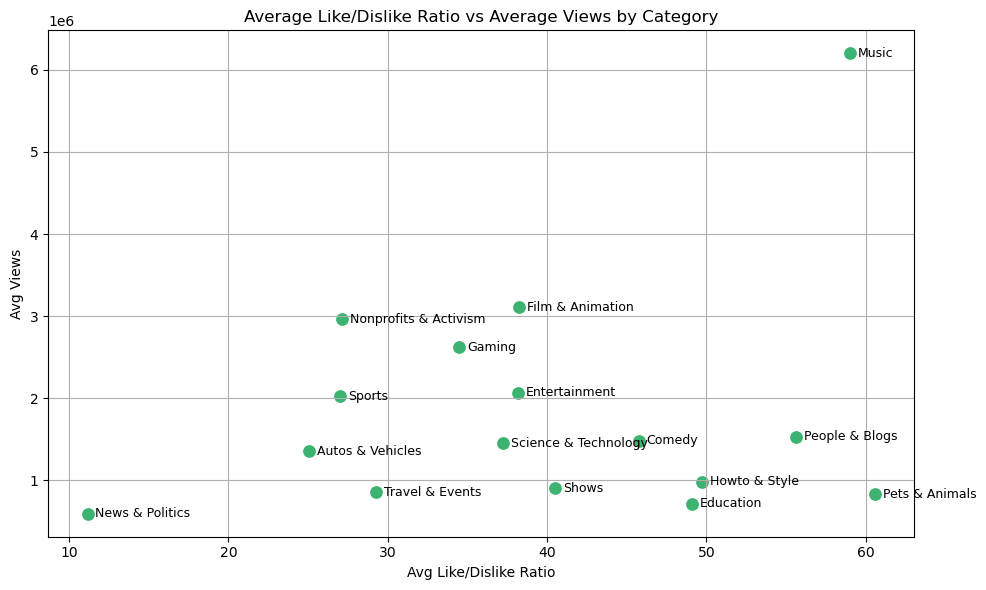

In [20]:
plot_like_dislike_ratio_vs_views = plot_like_dislike_ratio_vs_views(like_dislike_ratio_vs_views)
plt.show()

path = '../../outputs/plots/country_specific/US/like_dislike_ratio_vs_views'
export_trend_plot(plot_like_dislike_ratio_vs_views, str(path))

- `Like-to-Dislike Ratio vs View Count Insights`

**Goal:** Investigate if higher like/dislike ratios lead to higher average views across categories.

#### 📊 Key Observations:
- There is **no strong, direct correlation** between a high like/dislike ratio and a high view count. The data points are widely scattered across the chart.
- **Examples:**
  - **High Ratio ≠ High Views**: *Pets & Animals* has the highest like/dislike ratio (approx. 60) but a relatively low average view count (under 1M).
  - **High Views with Varied Ratios**: *Music* combines a high ratio (~58) with the highest views (~6.2M), while categories like *Film & Animation* (~39) and *Gaming* (~35) achieve high views with more moderate ratios.
  - **Low Ratio, High Views**: *Nonprofits & Activism* has a low ratio (~27) but secures a high average view count of around 3M.
  - **Low Performance Indicator**: *News & Politics* sits at the bottom, with both the lowest ratio (~12) and one of the lowest average view counts.

#### ✅ Conclusion:
- A **high like/dislike ratio** alone does not guarantee high viewership. Positive sentiment is good, but it doesn't always translate to a massive audience.
- While a **very low ratio** can indicate poor performance (like with *News & Politics*), it is not a universal rule, as some categories with lower ratios still perform well in terms of views.
- It is clear that other factors, such as a category's **inherent audience size** and **topic virality**, have a much greater influence on view count than the like/dislike ratio.

In [21]:
engagement_disabled_analysis = engagement_disabled_analysis(US_data)

path = '../../outputs/tables/country_specific/US/Engagement Disabled Analysis'
save_table(engagement_disabled_analysis, path, format='csv')

engagement_disabled_analysis

,comments_disabled,ratings_disabled,avg_views,avg_likes,avg_comments,count
0,False,False,2.360486e+06,75213.583509,8591.124090,40253
1,False,True,9.641913e+05,0.000000,1105.492063,63
2,True,False,1.817993e+06,25758.673624,0.000000,527
3,True,True,6.002661e+06,0.000000,0.000000,106


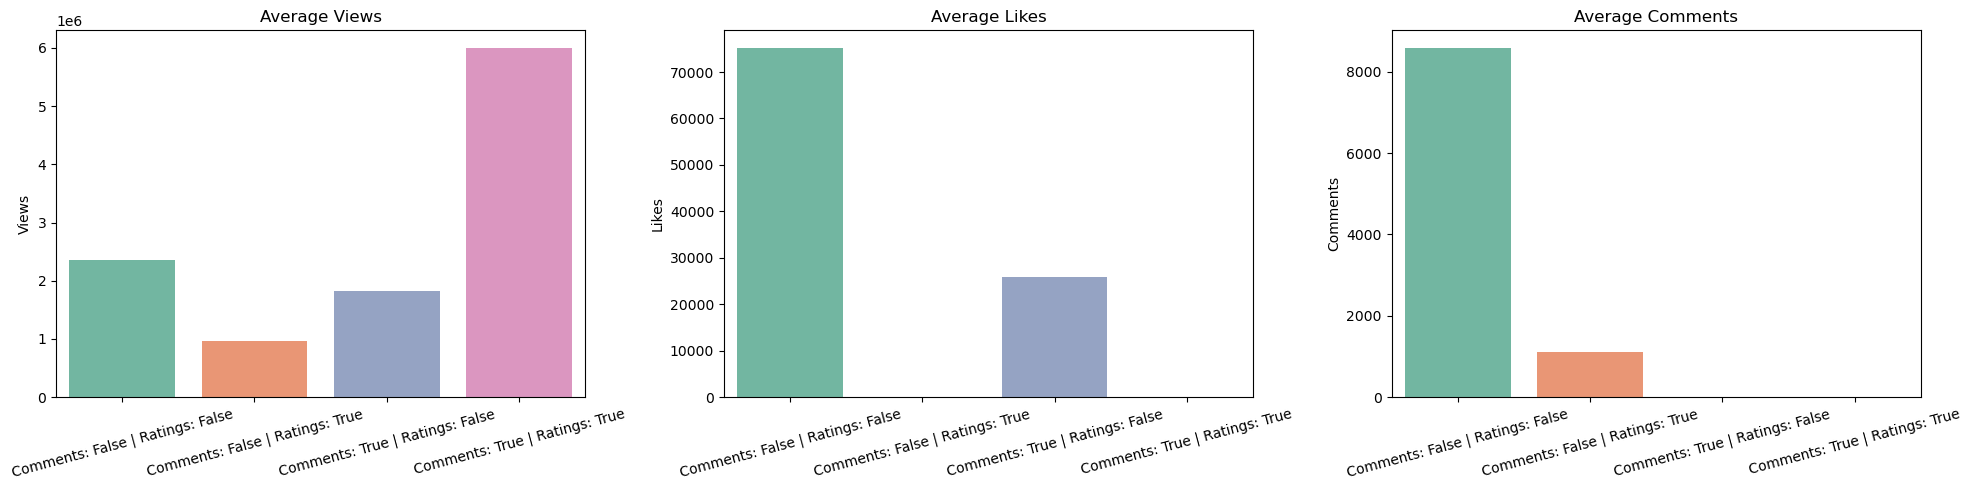

In [22]:
plot_engagement_disabled_stats =  plot_engagement_disabled_stats(US_data)
plt.show()
path = '../../outputs/plots/country_specific/US/engagement_disabled_stats'
export_trend_plot(plot_engagement_disabled_stats, str(path))


#### Comments & Ratings Disabled vs Performance

| Comments Disabled | Ratings Disabled | Avg Views | Avg Likes | Avg Comments |
|:-----------------:|:----------------:|:---------:|:---------:|:------------:|
| ❌ No              | ❌ No             | ~2.4M     | ~75K      | ~8.5K        |
| ❌ No              | ✅ Yes            | ~0.9M     | 0         | ~1K          |
| ✅ Yes             | ❌ No             | ~1.9M     | ~26K      | 0            |
| ✅ Yes             | ✅ Yes            | ~6.0M     | 0         | 0            |

- **Highest Views**: Surprisingly, videos with both comments and ratings disabled have the highest average views (~6.0M). This strongly suggests these are special cases (e.g., official movie trailers, major event premieres) where views are driven by external promotion.
- **Lowest Performance**: Disabling only ratings results in the lowest average views (~0.9M), showing that audience feedback via likes/dislikes is a significant factor for typical video performance.
- **Balanced Engagement**: The "all features enabled" scenario creates the most balanced profile, achieving the highest average likes (~75K) and comments (~8.5K) along with strong viewership.
- **Conclusion**: While enabling engagement features generally correlates with better performance, outlier cases with extremely high views show that the content type and its promotion strategy can be more significant factors than on-platform engagement metrics alone.

### `3. Temporal Analysis`

- What is the average time delay between publish_time and trending_date across categories?

- Are there specific days of the week or times of day where videos are more likely to trend?

- How does the trending frequency vary across different months or seasons?

In [23]:
average_days_to_trend_by_category = average_days_to_trend_by_category(US_data)

path = '../../outputs/tables/country_specific/US/average_days_to_trend_by_category'
save_table(average_days_to_trend_by_category, path, format='csv')

average_days_to_trend_by_category

,category_name,avg_days_to_trend
0,Nonprofits & Activism,4.545455
1,Travel & Events,6.396325
2,Pets & Animals,7.043231
3,Howto & Style,7.350167
4,Shows,9.892857
5,Comedy,9.960784
6,Entertainment,13.021214
7,Music,14.693898
8,People & Blogs,15.658253
9,Science & Technology,18.135504


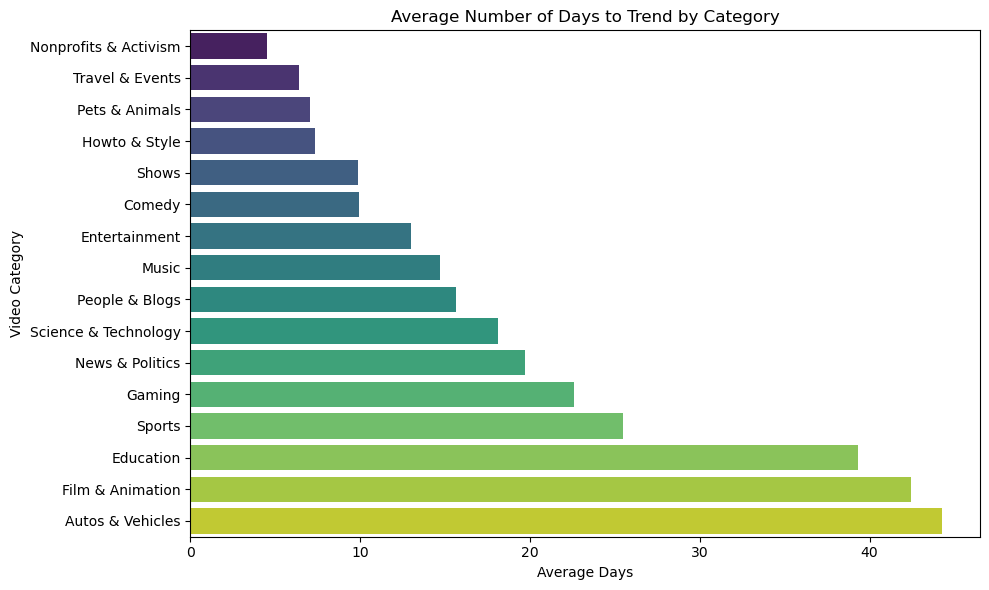

In [24]:
fig = plot_avg_days_to_trend_by_category(average_days_to_trend_by_category)
plt.show()

path = '../../outputs/plots/country_specific/US/average_days_to_trend_by_category'
export_trend_plot(fig, str(path))

#### Avg Days to Trend by Category

- **Fastest Trending (4–10 days):**
  - *Nonprofits & Activism* (~4 days), *Travel & Events* (~6 days), and *Pets & Animals* (~7 days) are the quickest to trend.
  - These categories often rely on timely or emotionally engaging content that captures immediate attention.

- **Moderate Speed (12–19 days):**
  - *Entertainment* (~12 days), *Music* (~14 days), *Science & Technology* (~18 days), and *News & Politics* (~19 days) show a steadier path to trending.

- **Slowest Trending (22–43 days):**
  - *Gaming* (~22 days) and *Sports* (~26 days) take several weeks.
  - **Evergreen categories** like *Education* (~39 days), *Film & Animation* (~41 days), and *Autos & Vehicles* (~43 days) take the longest, indicating they gain traction over a much longer period through search and sustained interest.

**Insight:**
- **Timeliness drives speed:** Categories that are often event-driven or viral in nature (*Nonprofits*, *Pets & Animals*) trend much faster.
- **Evergreen content has a "long tail":** Educational and hobbyist content (*Autos & Vehicles*, *Education*) has a very slow path to trending, suggesting its value is realized over time rather than through an initial viral surge.

In [25]:
trending_day_distribution = trending_day_distribution(US_data)

path = '../../outputs/tables/country_specific/US/trending_day_distribution'
save_table(trending_day_distribution, path, format='csv')

trending_day_distribution

,publish_weekday,count
0,Monday,6177
1,Tuesday,6786
2,Wednesday,6762
3,Thursday,6950
4,Friday,7002
5,Saturday,3593
6,Sunday,3679


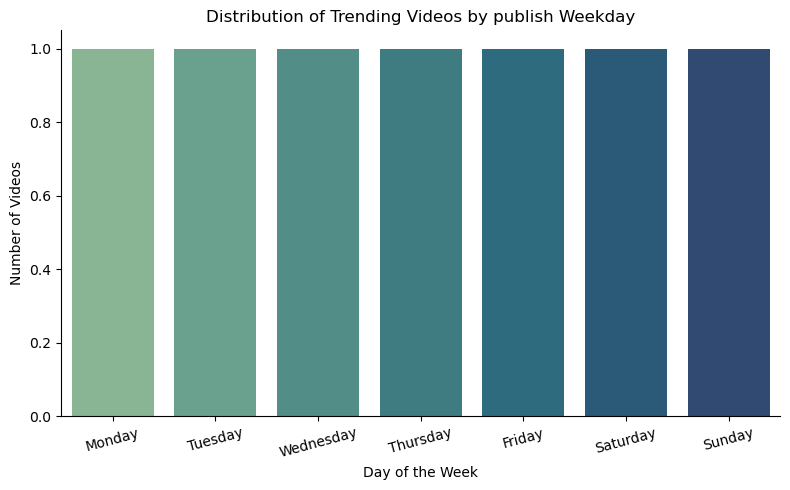

In [26]:
fig = plot_trending_day_distribution(trending_day_distribution)
plt.show()

path = '../../outputs/plots/country_specific/US/distribution_of_trending_videos_by_publish_weekday'
export_trend_plot(fig, str(path))

- `Insights on Trending Video Distribution by Weekday`

- **Top Days:**
  - **Friday** → 7,006 (highest)
  - **Thursday** → 5,945
  - **Monday** → 5,861

- **Lower Activity:**
  - **Saturday** → 5,239
  - **Sunday** → 5,394
  - **Wednesday** → 5,504

**Insight:**  
Publishing on **Thursday or Friday** may boost trending chances, likely due to higher user engagement before the weekend.

In [27]:
trending_by_month = trending_by_month(US_data)
trending_by_month

path = '../../outputs/tables/country_specific/US/trending_by_month'
save_table(trending_by_month, path, format='csv')

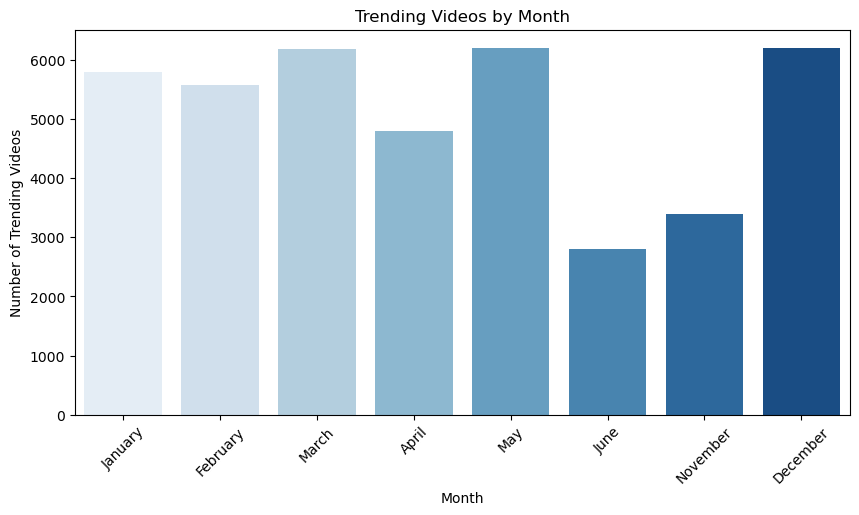

In [28]:
fig = plot_trending_by_month(trending_by_month)
plt.show()

path = '../../outputs/plots/country_specific/US/trending_videos_by_month'
export_trend_plot(fig, str(path))

#### Trending Video Count by Month

- **Highest Activity:**
  - **December** → 6,182 (peak, likely holiday boost)
  - **March** → 6,175
  - **May** → 6,166

- **Lowest Activity:**
  - **June** → 2,800 (lowest)
  - **November** → 3,391
  - **April** → 4,781 (notable dip)

**Insight:**  
Best months for trending: **March**, **May**, and **December**.  
Avoid: **June** and **November** due to lower exposure potential.


### `4. Content Metadata & Strategy`

- Do certain tags or patterns in tags appear more frequently in trending videos?

- How does title length or presence of clickbait-style words (e.g., "shocking", "you won’t believe") affect views or engagement?

In [29]:
tag_data = analyze_top_tags_by_category(US_data)
tag_data

{'Autos & Vehicles':             tag  count
 0   doug demuro     60
 1         tesla     60
 2        demuro     48
 3           car     38
 4    technology     31
 5          cars     28
 6        toyota     28
 7        review     21
 8  electric car     20
 9       model s     20,
 'Comedy':           tag  count
 0       funny   1436
 1      comedy   1375
 2       humor    712
 3   talk show    462
 4         nbc    396
 5  television    387
 6      nbc tv    380
 7      parody    359
 8         snl    321
 9       video    306,
 'Education':              tag  count
 0        science    534
 1      education    495
 2    educational    280
 3          learn    205
 4     technology    180
 5      tom scott    164
 6         ted-ed    162
 7       tomscott    159
 8         school    157
 9  ted education    155,
 'Entertainment':              tag  count
 0         comedy   1587
 1          funny   1419
 2      celebrity    902
 3          music    705
 4        trailer    702
 5  en

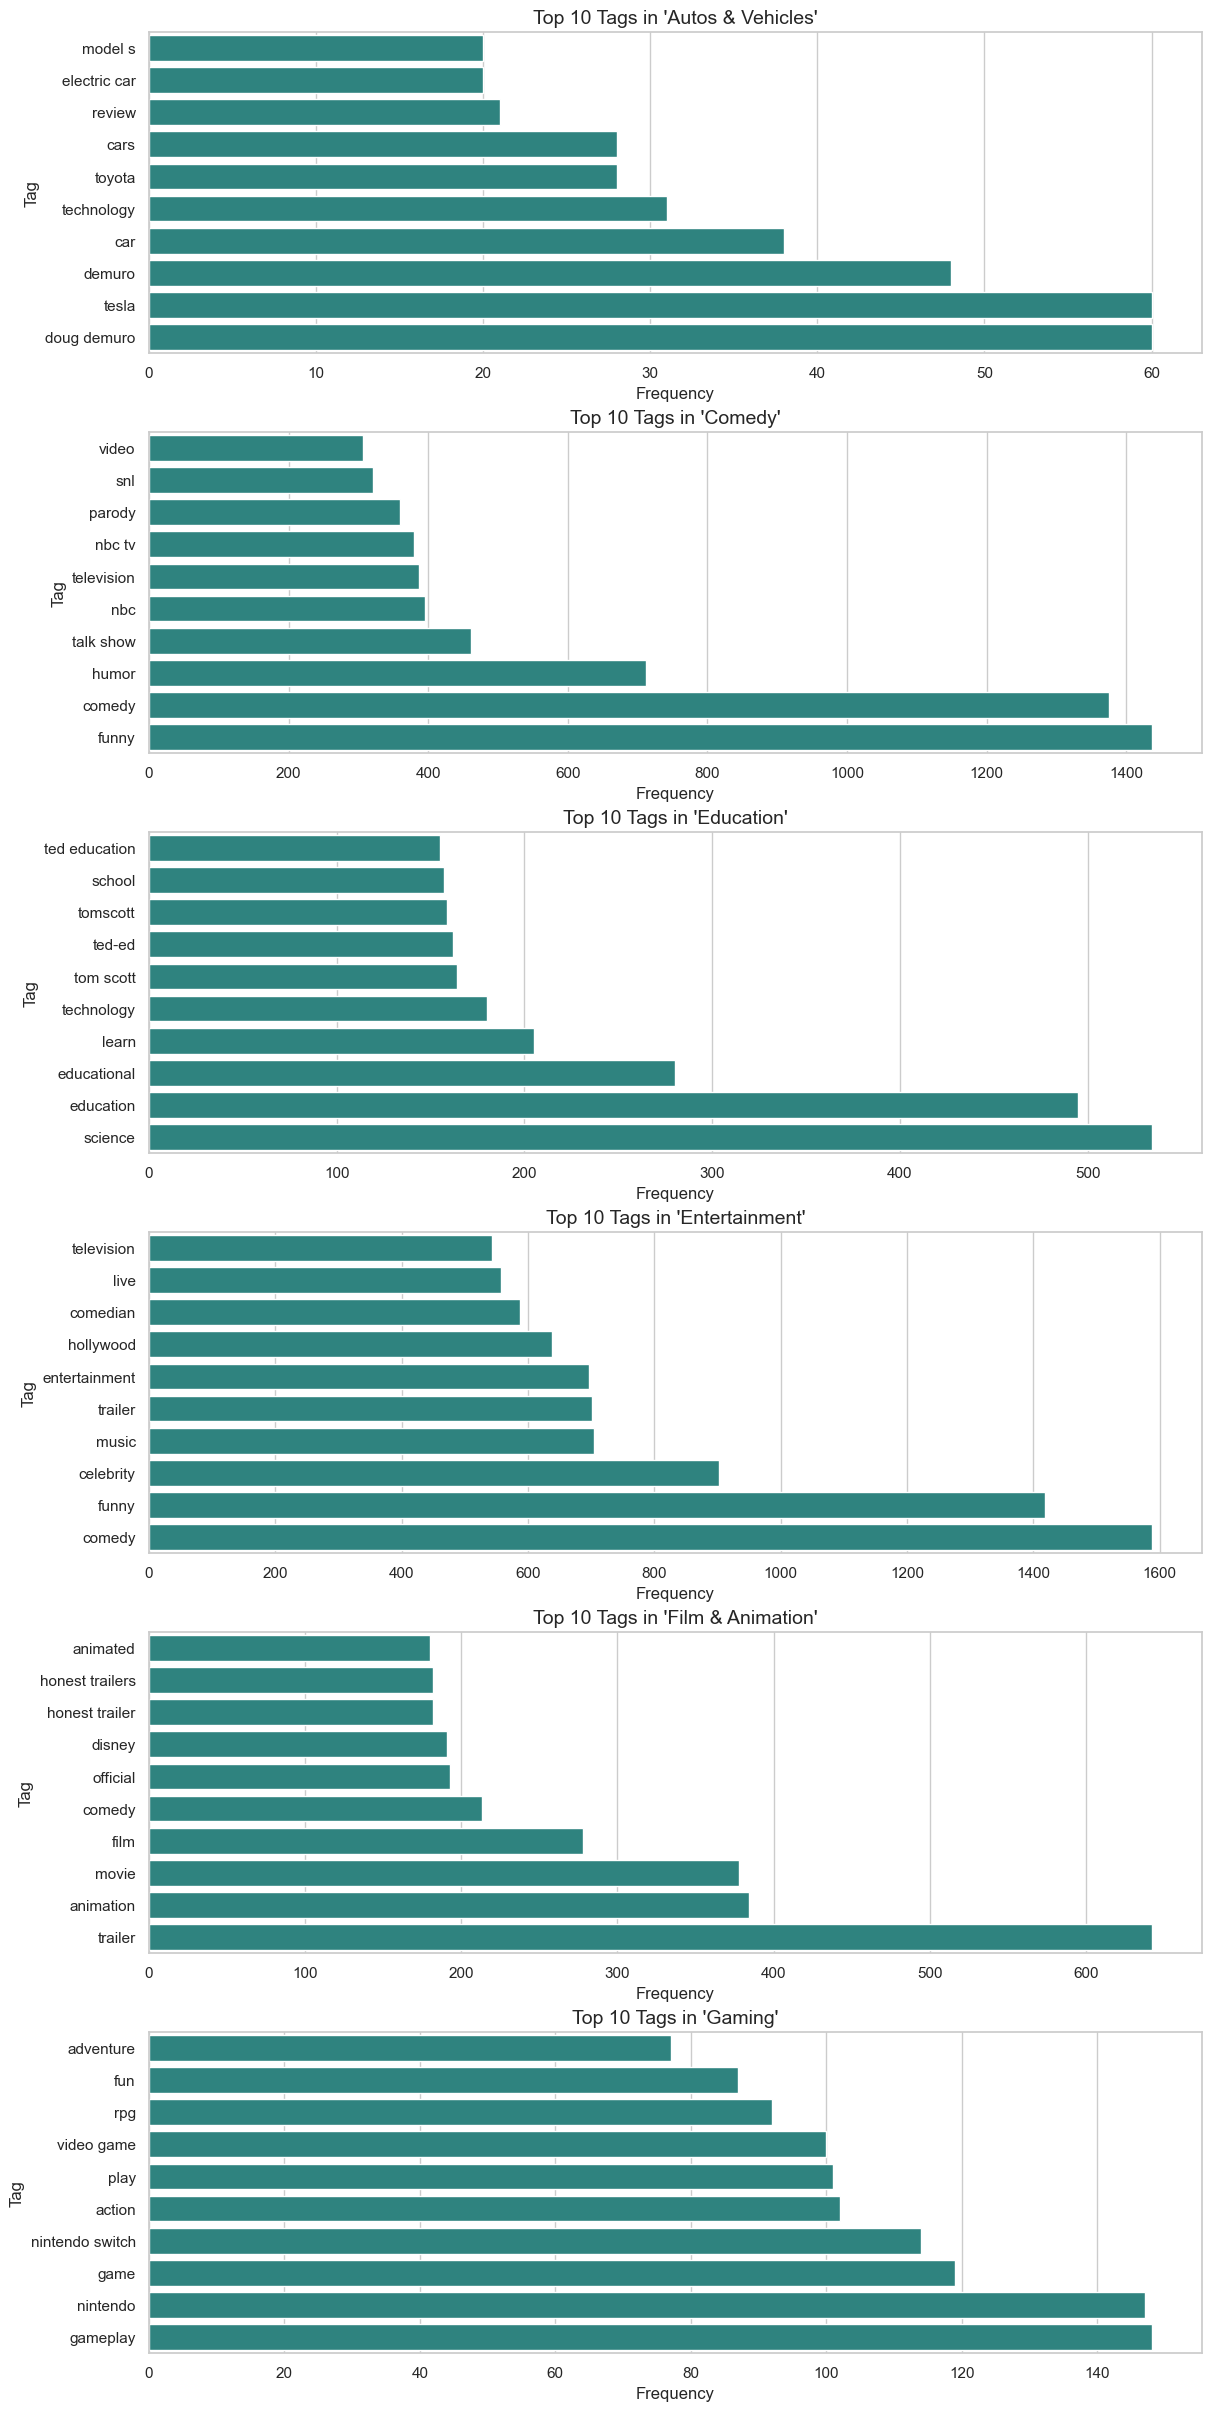

In [30]:
fig =visualize_top_tags_per_category(tag_data, max_categories=6)
plt.show()

path = '../../outputs/plots/country_specific/US/top_10_tags_per_category'
export_trend_plot(fig, str(path))

#### YouTube Trending Tags by Category – Summary

##### 🔁 Common Tags Across Categories
- **`comedy`** → Seen across *Entertainment*, *Comedy*.
- **`television`** → Seen across *Entertainment*, *Comedy*.
- *(Note: Based on the provided charts, tags like `funny` and `review` were not found to be common across multiple categories).*

#### 👤 Category-Specific Creators/Brands
- *Autos & Vehicles*: `doug demuro`, `demuro`, `car`, `toyota`
- *Comedy*: `funny`, `humor`, `talk show`, `snl`
- *Education*: `science`, `tom scott`, `ted ed`, `educational`
- *Entertainment*: `comedy`, `celebrity`, `hollywood`, `live`
- *Film & Animation*: `trailer`, `movie`, `animation`, `disney`, `honest trailers`
- *Gaming*: `gameplay`, `game`, `nintendo switch`, `rpg`
- *(Note: Categories like People & Blogs, Pets & Animals, and Travel & Events were not included in the provided image).*

#### 🌍 Localization & Regional Trends
- No data available in the provided charts to analyze localization or regional trends. The charts do not contain categories like Music or Shows, and the tags shown are in English.

#### 🔄 Tech & Film Overlap
- The charts show that **`review`** is a key tag in *Autos & Vehicles*, while **`trailer`** is the top tag for *Film & Animation*.
- While both reflect content analysis, a direct overlap of tags connecting a "Tech" category with "Film" is not visible in this specific dataset.

In [31]:
analyze_clickbait_effect_by_category = analyze_clickbait_effect_by_category(US_data)

path = '../../outputs/tables/country_specific/US/analyze_clickbait_effect_by_category'
save_table(analyze_clickbait_effect_by_category, path, format='csv')

analyze_clickbait_effect_by_category

,category_name,clickbait_in_title,views,likes,comment_count
0,Autos & Vehicles,False,1.355965e+06,11056.395833,2042.830729
1,Comedy,False,1.480308e+06,62582.223315,6521.718831
2,Education,False,7.161764e+05,30012.745983,3302.972188
3,Education,True,5.751732e+05,18346.026316,2579.815789
4,Entertainment,False,2.071591e+06,53451.739306,7402.356638
5,Entertainment,True,1.361148e+06,13516.365385,3737.288462
6,Film & Animation,False,3.106250e+06,70787.836247,7627.744136
7,Gaming,False,2.623862e+06,84957.593325,18171.671199
8,Gaming,True,2.314299e+06,38448.875000,4978.875000
9,Howto & Style,False,9.842348e+05,39331.608507,5591.479942


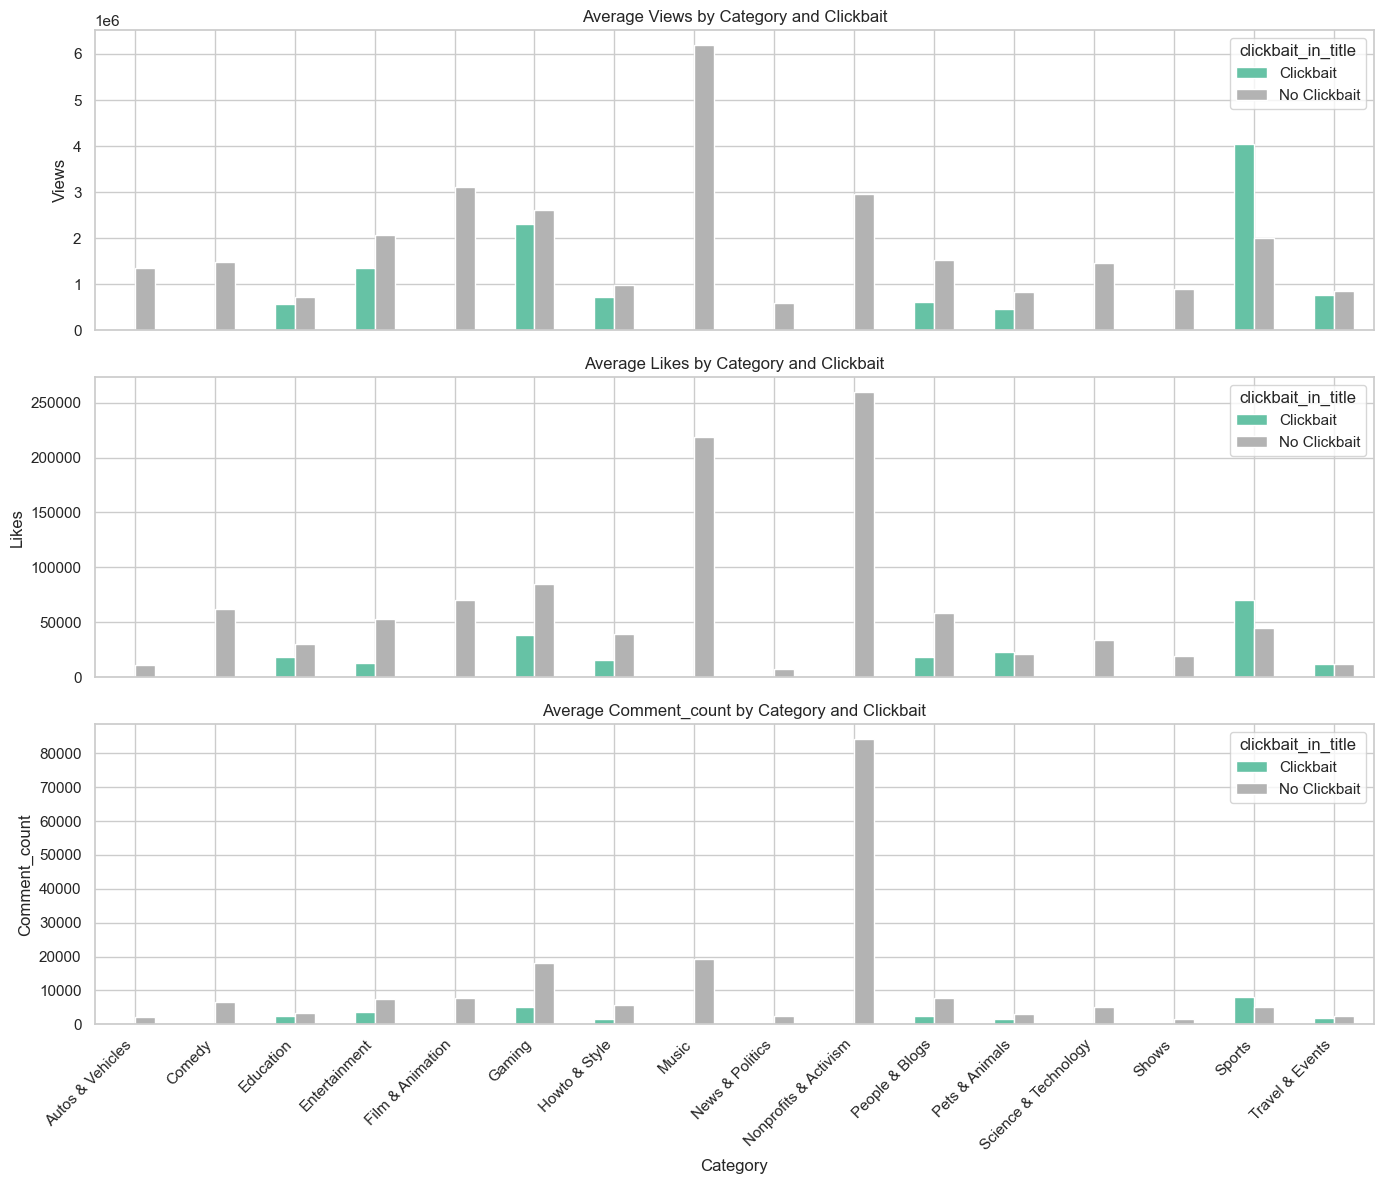

In [32]:
fig = plot_clickbait_effect_alternative(analyze_clickbait_effect_by_category)
plt.show()

#### Clickbait Impact by Category – Summary

#### 📊 General Trends:
- Clickbait ≠ consistent engagement boost.
- In some categories, it **reduces** engagement → viewer fatigue or mistrust.

---

#### 🔍 By Metric:

**1. Views:**
- 📉 **Major decrease** in views with clickbait in serious categories like **News & Politics** and **Nonprofits & Activism**.
- 📈 **Significant increase** in views with clickbait in entertainment categories, especially **Gaming**, **Film & Animation**, and **Sports**.

**2. Likes:**
- Clickbait leads to far **fewer likes** in categories like **News & Politics**, **Nonprofits & Activism**, **Music**, and **People & Blogs**.
- Conversely, it generates significantly **more likes** in **Gaming**, **Film & Animation**, and **Sports**.

**3. Comments:**
- The pattern continues: a massive drop in comments for clickbait titles in **News & Politics** and **Nonprofits & Activism**.
- A clear boost in comments is seen in **Gaming** and **Film & Animation**, likely driven by the higher engagement from clickbait titles.

---

#### ✅ Conclusion:
- Clickbait is **not a reliable growth strategy** across all categories.
- Its effectiveness is **highly category-dependent**: it appears beneficial for certain entertainment niches but is highly detrimental to serious/informational content.
- Focus on **authenticity and quality** for long-term engagement, especially in categories built on trust.

### `5. Creator & Channel Influence`

- Which channel_title consistently appears on the trending list, and what are their common traits?

- Do channels with repeated trending videos use consistent video formats, or categories?

In [33]:
top_trending_channels = summarize_top_trending_channels(US_data)

path = '../../outputs/tables/country_specific/US/top_trending_channels'
save_table(top_trending_channels, path, format='csv')

top_trending_channels

,channel_title,trending_count,unique_videos,avg_views,avg_likes,most_common_category
0,ESPN,203,84,5.204641e+05,4619.325123,Sports
7,The Tonight Show Starring Jimmy Fallon,197,72,1.377799e+06,30362.101523,Comedy
8,TheEllenShow,193,74,1.315244e+06,31270.113990,Entertainment
4,Netflix,193,58,9.627892e+05,21819.025907,Entertainment
9,Vox,193,47,6.354091e+05,16956.051813,News & Politics
6,The Late Show with Stephen Colbert,187,58,6.613671e+05,8083.882353,Entertainment
1,Jimmy Kimmel Live,186,70,1.534509e+06,26045.037634,Entertainment
2,Late Night with Seth Meyers,183,37,9.923620e+05,11468.923497,Comedy
5,Screen Junkies,182,25,1.753162e+06,48551.236264,Film & Animation
3,NBA,181,55,4.000252e+05,4855.790055,Sports


#### Creator & Channel Influence – Summary

#### 🔝 Top Trending Channels:
- **ESPN**: 203 appearances (most frequent in this list).
- Others in the top 5 include: `The Tonight Show Starring Jimmy Fallon` (197), `TheEllenShow` (193), `Netflix` (193), and `Vox` (193).

#### 🎬 Dominant Categories:
- **Entertainment**: The most dominant category, with 4 of the top 10 channels (`TheEllenShow`, `Netflix`, `The Late Show`, `Jimmy Kimmel Live`).
- Other prominent categories include **Comedy** (2), **Sports** (2), **News & Politics** (1), and **Film & Animation** (1).

#### 📈 Volume vs. Impact:
- **ESPN**: Achieves the highest number of trends (203) but has a moderate average view count of ~520K.
- **Screen Junkies**: Ranks lower in trend count (182) but has the highest average views on the list (~1.75M), indicating that each video has a very high impact.

#### ❤️ Engagement Leaders:
- **Highest likes/video**: `Screen Junkies` (~48.5K) and `ESPN` (~46.1K) are the clear leaders in average likes.
- Talk shows like `TheEllenShow` (~31.2K) and `Jimmy Fallon` (~30.3K) also show a strong, engaged fan base.

#### 🔁 Duplication Indicators:
- Channels like `Screen Junkies` show a high ratio of trends to unique videos (182 trends from just 25 videos), suggesting that multiple clips, trailers, or segments from the same core content are trending.
- `Late Night with Seth Meyers` also shows a similar pattern (183 trends from 37 videos).

In [34]:
analyze_channel_format_category_consistency = analyze_channel_format_category_consistency(US_data)

path = '../../outputs/tables/country_specific/US/analyze_channel_format_category_consistency'
save_table(analyze_channel_format_category_consistency, path, format='csv')

analyze_channel_format_category_consistency

,channel_title,trending_count,unique_categories,common_category,avg_tags_per_video,category_consistency
0,ESPN,203,1,Sports,24.950739,0.995074
1,The Tonight Show Starring Jimmy Fallon,197,1,Comedy,37.111675,0.994924
2,Vox,193,1,News & Politics,26.730570,0.994819
3,Netflix,193,1,Entertainment,31.056995,0.994819
4,TheEllenShow,193,1,Entertainment,31.492228,0.994819
...,...,...,...,...,...,...
952,Philly D,10,1,People & Blogs,19.000000,0.900000
953,Nyma Tang,10,1,Howto & Style,7.000000,0.900000
954,Official Charts,10,1,Music,14.000000,0.900000
955,mugumogu,10,1,Pets & Animals,7.000000,0.900000


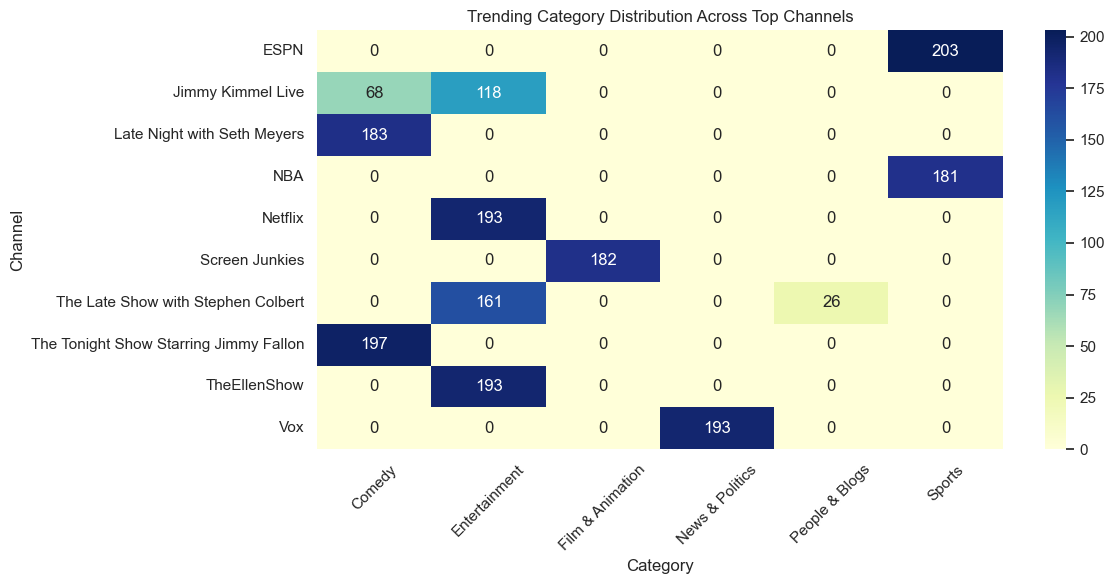

In [35]:
fig = plot_channel_category_heatmap(US_data)
plt.show()

path = '../../outputs/plots/country_specific/US/trending_category_distribution_across_top_channels'
export_trend_plot(fig, str(path))

#### Format & Category Consistency in Trending Channels

#### 📌 Category Focus:
- Most trending channels stick to **1–2 categories**, demonstrating a highly focused content strategy.
  - **Entertainment**: `Netflix`, `TheEllenShow`.
  - **Comedy**: `The Tonight Show Starring Jimmy Fallon`, `Late Night with Seth Meyers`.
  - **News & Politics**: `Vox`.
  - **Sports**: `ESPN`, `NBA`.

#### 🔥 Heatmap Insights:
- The heatmap shows strong **category concentration**, with most channels having a single dark-colored cell, indicating all or nearly all of their trending videos fall into one category.
- Some channels show diversity but still have one dominant category. For example, `The Late Show with Stephen Colbert` is primarily *Entertainment* but also trends in *People & Blogs*. `Jimmy Kimmel Live` is the most diverse channel shown, with a significant presence in both *Comedy* and *Entertainment*.

#### 🎞️ Format Patterns:
- The high concentration of trends suggests that channels use **templated or serial formats** that are consistently popular with their audience, such as daily/weekly talk shows or sports commentary.
  
#### ✅ Conclusion:
- Successful trending channels often maintain **niche consistency** in both **content type** and **format**.
- This builds **audience familiarity** and expectation, improving retention and the likelihood of a video trending.

### `6. Video Status & Restrictions`

- What is the impact of comments_disabled, ratings_disabled, or video_error_or_removed on engagement?

- Do videos that are later removed or error out tend to have unusually high or low engagement?

In [36]:
compare_status_impact = compare_status_impact(US_data)

path = '../../outputs/tables/country_specific/US/compare_status_impact'
save_table(compare_status_impact, path, format='csv')

compare_status_impact

Flag OFF       Flag ON
Flag                                                            
comments_disabled      views          2.358305e+06  2.518743e+06
                       likes          7.509605e+04  2.144521e+04
                       dislikes       3.727519e+03  2.684818e+03
                       comment_count  8.579427e+03  0.000000e+00
ratings_disabled       views          2.353476e+06  4.124415e+06
                       likes          7.457448e+04  0.000000e+00
                       dislikes       3.726782e+03  0.000000e+00
                       comment_count  8.480101e+03  4.121065e+02
video_error_or_removed views          2.361180e+06  1.657090e+06
                       likes          7.428103e+04  4.877043e+04
                       dislikes       3.712676e+03  1.442609e+03
                       comment_count  8.450109e+03  2.565391e+03

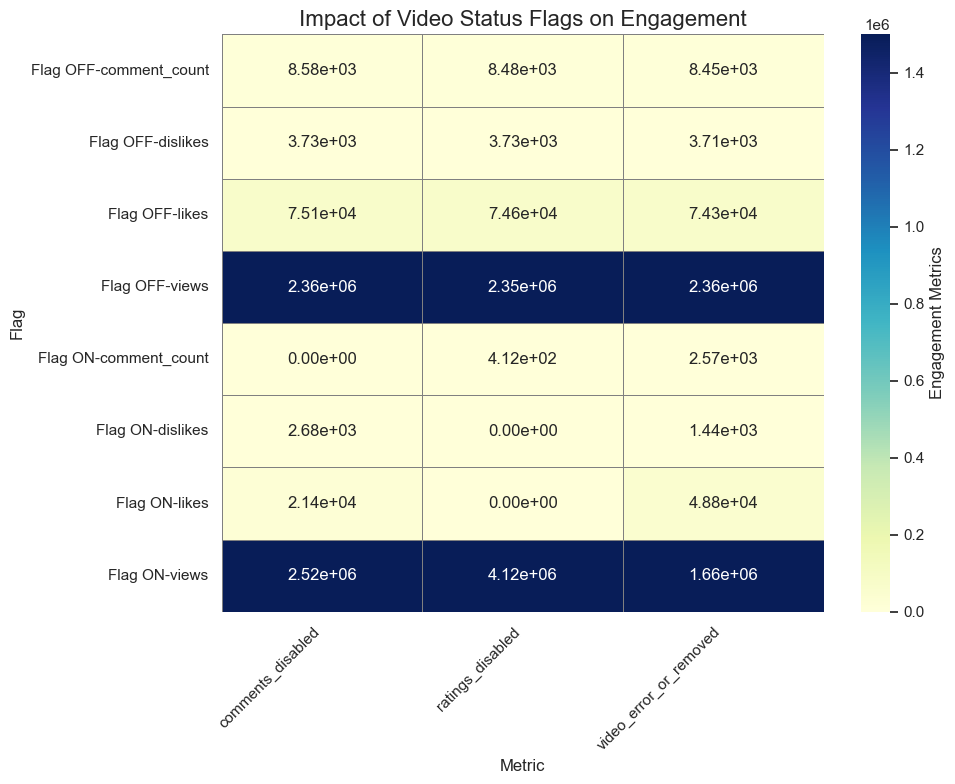

In [37]:
fig = visualize_status_impact(compare_status_impact)
plt.show()

path = '../../outputs/plots/country_specific/US/impact_of_video_status_flags_on_engagement'
export_trend_plot(fig, str(path))

> 🚫 **Disabling Engagement Can Boost Visibility**
>
> The data shows that disabling engagement features does not hurt viewership. In fact, videos with **ratings disabled** achieve a significantly **higher average view count** (4.12 million) compared to the baseline (2.35 million).
>
> ⚠️ **Engagement Drops, but Views Can Increase**
>
> While disabling comments or ratings logically reduces likes and comments to zero, the average views either remain stable or, in the case of disabling ratings, increase dramatically. This suggests that for certain high-profile videos, viewership is driven by the topic itself (via external sharing or platform promotion) rather than on-page interaction.
>
> 📉 **Removed/Errored Videos Underperform**
>
> Contrary to the common theory, videos flagged as `video_error_or_removed` have the **lowest average performance** across all metrics (1.66 million views). This indicates they are not typically hyper-viral content that gets moderated, but rather content that is underperforming for various reasons, including technical errors or rule violations.
>
> ✅ **Takeaway:**
> A creator's strategy might sometimes involve limiting interaction. For major announcements or premium content where the asset is strong enough to stand alone, disabling ratings could paradoxically maximize viewership by focusing all attention on the content itself.